In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input/fitbit/Fitabase Data 4.12.16-5.12.16")
getwd()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **BELLABEAT - CASE STUDY**

**Scenario**

The company's officials believe that analyzing device fitness data could help the company grow. They expect the insights would help them guide the marketing strategy for the company.

# Approach

1. To guide the marketing strategy, we must target the population segment with the highest potential. Which population segment is more likely to buy fitness products?
2. Who constitutes the most - The health-conscious people who work out heavily or casual users ?**

By answering questions like these we may be able to figure out the target people for marketing.

**Business Task: Deliver results with insights that can tell the company which type of users to focus on and other usage statistics to understand the customer's usage in a comprehensive way.**

There are various CSV files. Try exploring them one by one. It is soon found out there are three main datasets.
**1. dailyActivity_merged**
**2. sleepDay_merged**
**3. weightLogInfo_merged**


Start with importing necessary libraries and store the CSV files in a variable.







In [ ]:
library(tidyverse)
library(dplyr)
library(lubridate)
daily_activity <- read.csv("/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv")
sleep_day <- read.csv("/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv")
weight_log <- read.csv("/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv")


Start exploring the CSV file by using **glimpse() and summary()**



# Exploring,Organising and little cleaning

In [ ]:
glimpse(daily_activity)
summary(daily_activity)


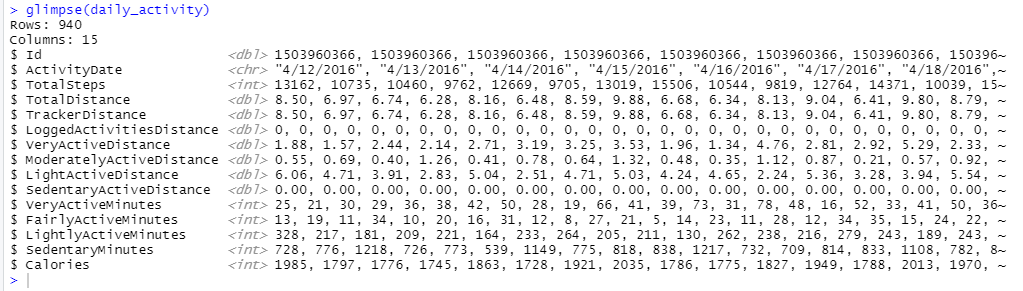
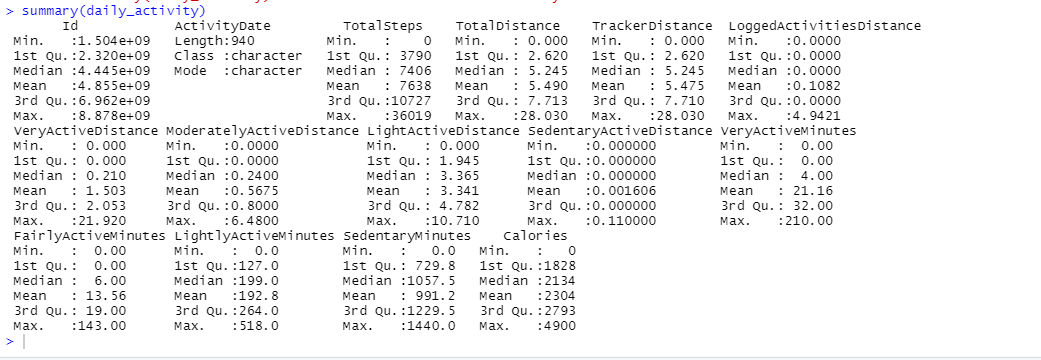

By glancing through the CSV file you note that Date and Time are in the same column. We can split them into seperate columns to make it more clean

In [ ]:
sleep_edit <- sleep_day %>% 
  separate(SleepDay,c("DAte","Time")," ")


Now we can say that the Daily Activity dataset has most of the important parameters except info about Sleep. We may now look to combine two dataset


In [ ]:
combined_sleep <- full_join(daily_activity,sleep_edit,by = c("Id"="Id","ActivityDate" = "DAte"))

What we did in the previous step comes handy here as we used the date column in addition to Id to merge the datasets.
Once merged use **summary()** to take a glance at the data


In [ ]:
summary(combined_sleep)
glimpse(combined_sleep)

We can see that it has many missing values.
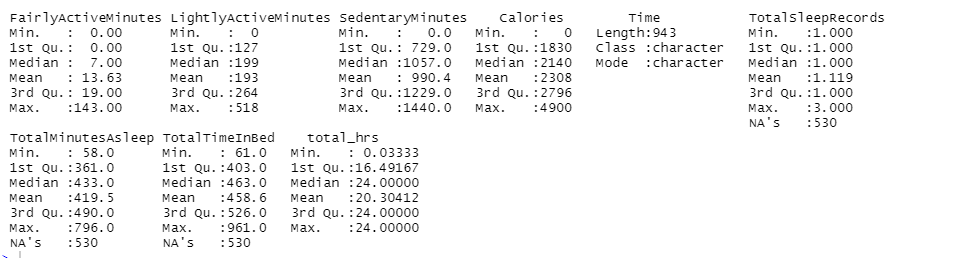

So let's have only the records for which all data is available. Instead of removing the null records, we can simply use **leftjoin()**

In [ ]:
only_sleep <- left_join(sleep_edit,daily_activity,by=c("Id"="Id","DAte" = "ActivityDate"))
glimpse(only_sleep)

To get a clear picture of non-sleep hours and sleep hours, let's create new columns

In [ ]:
only_sleep$nonSleep_hrs = (only_sleep$SedentaryMinutes+only_sleep$LightlyActiveMinutes+only_sleep$FairlyActiveMinutes+only_sleep$VeryActiveMinutes)/60
only_sleep$total = only_sleep$nonSleep_hrs + (only_sleep$TotalMinutesAsleep/60)
only_sleep

Going through the dataset we find that there are some hours where the data is **greater than 24** which is clearly wrong data. So it is better to **remove those data.**

In [ ]:
only_sleep_clean <- only_sleep[!(only_sleep$total > 24 ),]

Now that our data is clean we may proceed to analyse it. For the sake of simplicity we categorize the people into two - **Heavy User and Light User** based amount on their activity. We assume people with **more than 1 hour** of 'active' and 'very active' as heavy users and others as light users.

In [ ]:
only_sleep_clean$heavy_mins = only_sleep_clean$FairlyActiveMinutes+only_sleep_clean$VeryActiveMinutes 
only_sleep_clean$lite_mins = only_sleep_clean$SedentaryMinutes+only_sleep_clean$LightlyActiveMinutes +only_sleep_clean$TotalMinutesAsleep
only_sleep_clean$type = case_when(only_sleep_clean$heavy_mins > 60 ~ "Heavy User", TRUE ~ "Light User",)

You can take a look at the dataset if you want.Next we shall find out the number of users in each category using charts.

In [ ]:
only_sleep_clean

# Visualising

The next stage is visualising the data. For this we'll use **ggplot2** library

In [ ]:
library(ggplot2)

In [ ]:
ggplot(only_sleep_clean,aes(x=type,fill=type))+geom_bar()

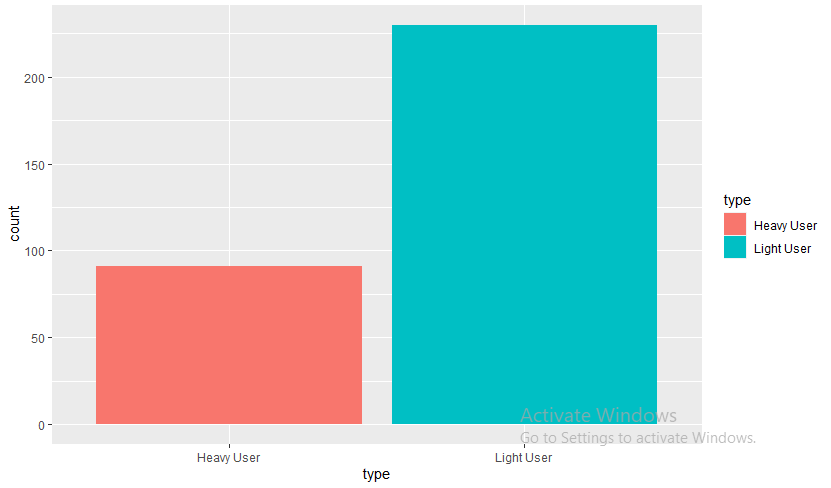

**Inference:**
We see that most of the people in the sample are light users.
Let's take a look at the calories burned by them

In [ ]:
ggplot(only_sleep_clean,aes(x=type,y=Calories,fill=type))+geom_boxplot(alpha=.2)+theme(legend.position = "none")+labs(title='Calories burned by Type')

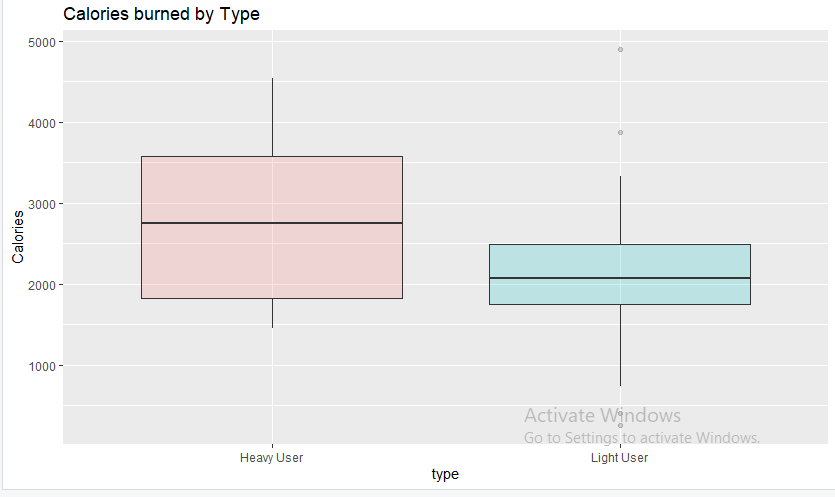

As expected we can see that Heavy Users tend to burn calories more.

**Inference :**
Heavy users mostly burn calories in the range of  **1800 to 3600**
Light users mostly burn calories in the range of **1700 to 2500**We see that most of the people in the sample are light users.

Now let's plot a histogram for Calories burned

In [ ]:
only_sleep_clean %>% 
  summarise(Id , Calories, type) %>% 
  ggplot(aes(Calories,fill=type)) + geom_histogram(bins=50)

only_sleep_clean %>% 
  summarise(Id , Calories, type) %>% 
  ggplot(aes(Calories)) + geom_histogram(aes(fill=..count..),bins=50)


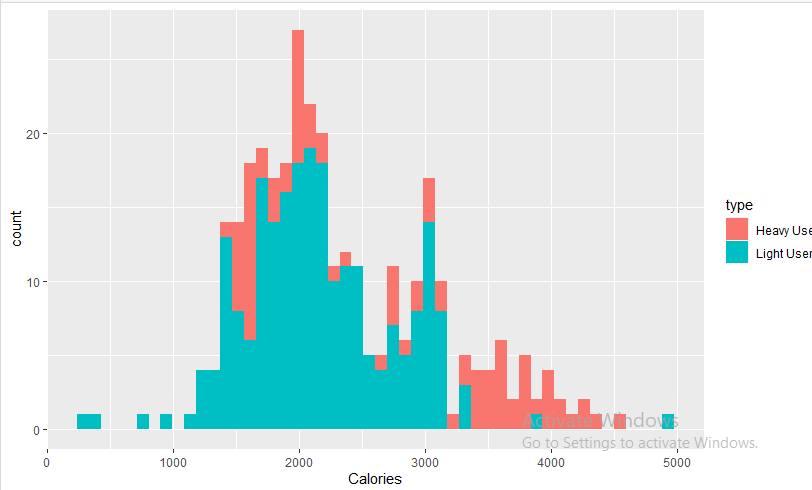

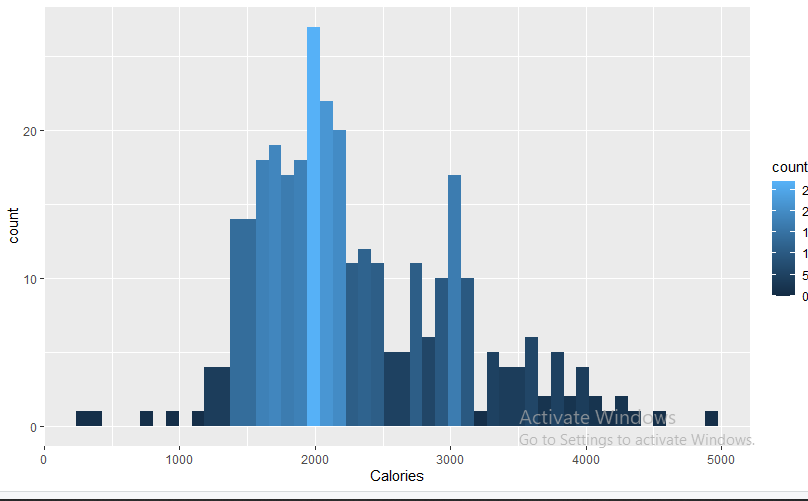

**Inference :**
Most of the sample poplation is concentrated around **'2000 calories burned'** mark.

In [ ]:
ggplot(only_sleep_clean,aes(x=TotalDistance,y=Calories)) +geom_jitter() +geom_smooth()

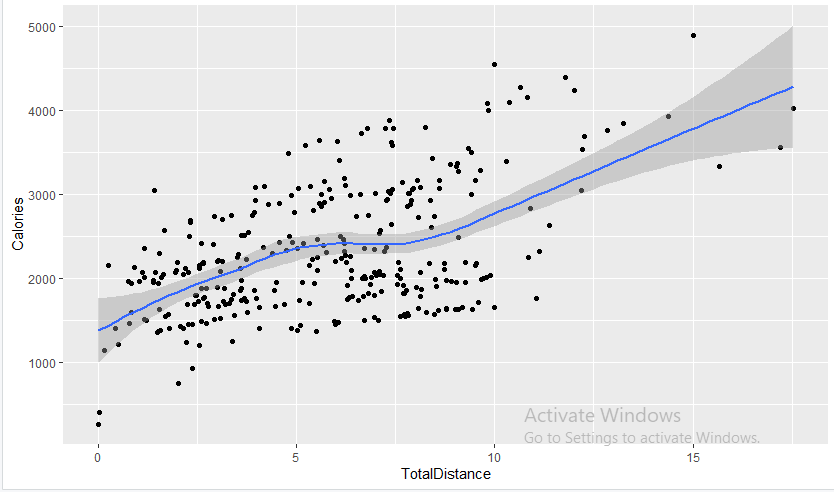

**Inference :**

As TotalDistance increases Calories also increases, but not so linearly which means the users are not only burning their calories through travelling by foot but my also other means.

In [ ]:
only_sleep_clean %>% 
  summarise(Id , TotalSteps, type) %>% 
  ggplot(aes(TotalSteps,fill=type)) + geom_histogram(bins=30)

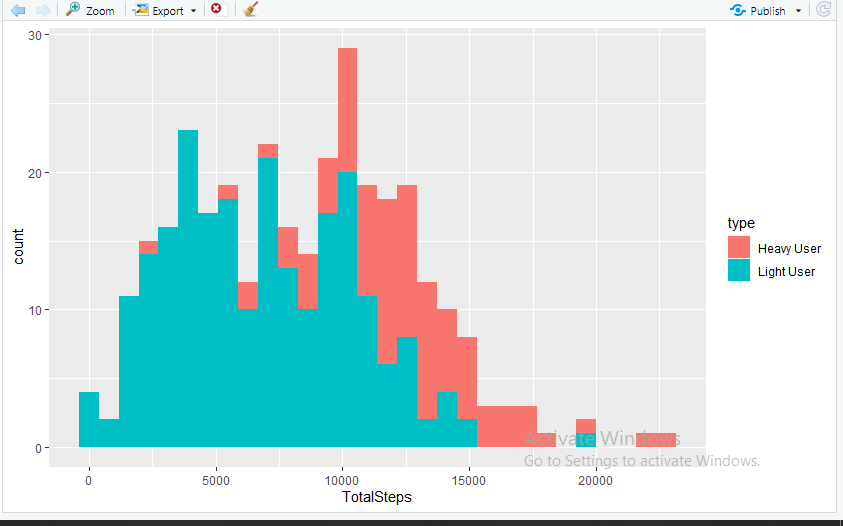

**Inference :**

Here we can see, below 10000 mark it comprises mostly of light users and above 10000,Heavy users

In [ ]:
ggplot(only_sleep_clean,aes(TotalDistance))+geom_histogram(binwidth = 5,color='black',fill='tomato',size=1,alpha=.4)+
  facet_wrap(~type)

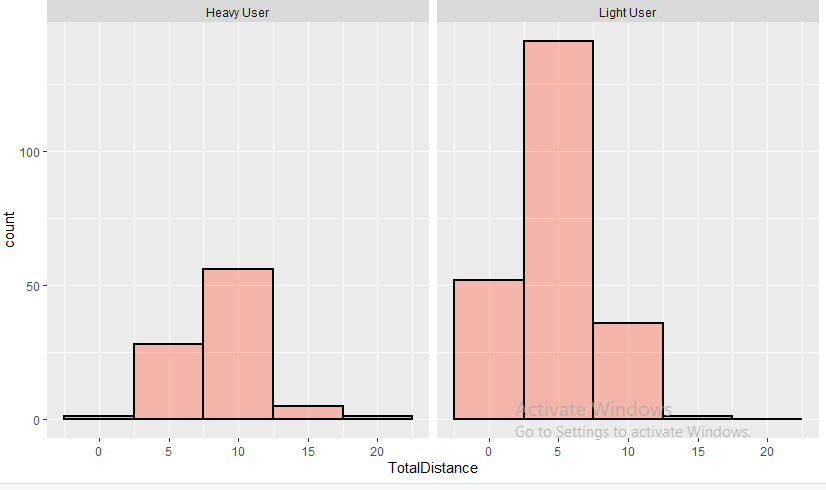

**Inference :**

We can see the data is concentrated at distance '10 to 15'. Most of the users travel a distance between 10 and 15

Next group people based on their no. of steps and plot it against Calories burned

In [ ]:
only_sleep_clean %>% 
  summarise(step_cat = factor(case_when(TotalSteps < 4000 ~ 'Less than 4k',
                                        TotalSteps >=4000 & TotalSteps<8000 ~ '4k to 8k',
                                        TotalSteps >=8000 & TotalSteps<11000 ~ '8k to 11k',
                                        TotalSteps >= 11000 ~ 'Greater than 11k'),levels = c('Less than 4k','4k to 8k','8k to 11k','Greater than 11k')),Calories,type) %>% 
  ggplot(aes(x=step_cat,y=Calories)) + geom_boxplot(aes(fill = step_cat)) + facet_wrap(~type) +
  xlab("No. of Steps") +
  labs(title = "No. of Steps Vs Calories Burned")+
  scale_fill_brewer(palette= 'Pastel1')

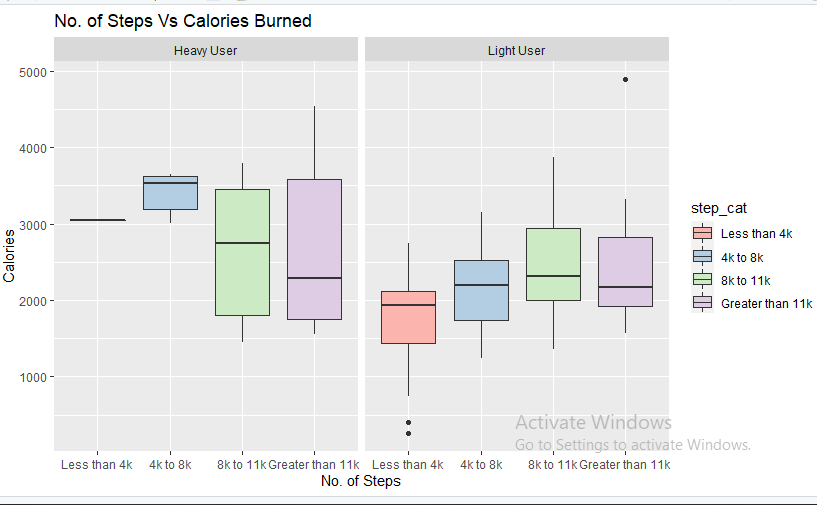

Next let's find out the relationship of the users with sleep

In [ ]:
ggplot(only_sleep_clean,aes(x=type,y=TotalMinutesAsleep/60))+geom_boxplot(color='black',fill='tomato',alpha=.4)

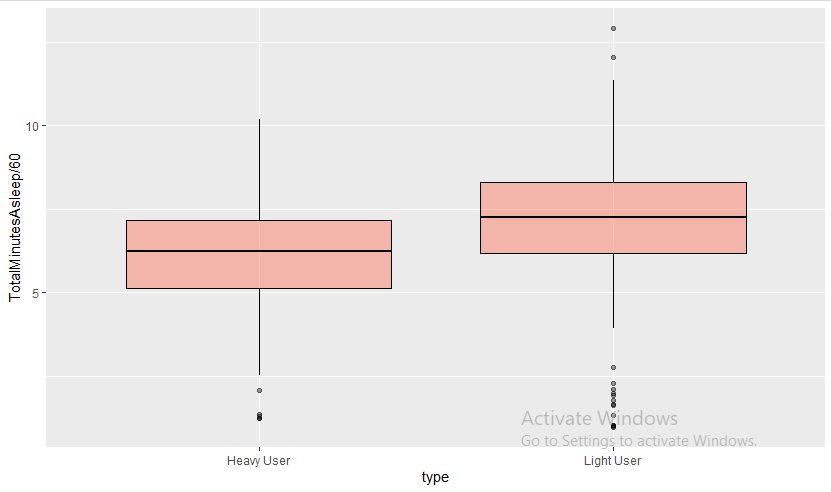

**Inference :**

We understand that as a whole, heavy user tend to get less sleep than that of Light Users. We can categorize them on their sleep pattern for more insights

In [ ]:
only_sleep_clean %>% 
  group_by(Id) %>% 
  summarise(Id,type,sleep_type=factor(case_when((TotalMinutesAsleep/60) < 6 ~ 'Inadequate Sleep',
                                        (TotalMinutesAsleep/60)>=6 & (TotalMinutesAsleep/60) < 8 ~ 'Adequate Sleep',
                                        (TotalMinutesAsleep/60)>=8 ~ 'Oversleep')),
            
            ) %>% 
  summarise(Id,sleep_type,type, .groups = 'drop') %>% 
  ggplot(aes(sleep_type)) +
  geom_bar(position = "dodge", aes(fill=type))+
  theme(legend.position="bottom",text = element_text(size = 20),plot.title = element_text(hjust = 0.5))

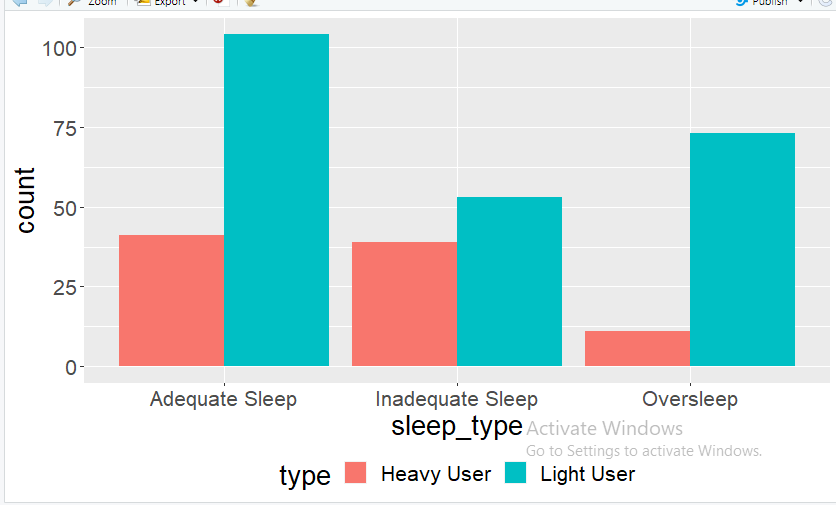

Though this gives us a fair idea, we could improve the visuals - better so if we could represent them with percentages

In [ ]:
only_sleep_clean %>% 
  group_by(Id) %>% 
  summarise(Id,type,sleep_type=factor(case_when((TotalMinutesAsleep/60) < 6 ~ 'Inadequate Sleep',
                                                (TotalMinutesAsleep/60)>=6 & (TotalMinutesAsleep/60) < 8 ~ 'Adequate Sleep',
                                                (TotalMinutesAsleep/60)>=8 ~ 'Oversleep')),
            
  ) %>% 
  summarise(Id,sleep_type,type, .groups = 'drop') %>% 
  ggplot(aes(type)) +
  geom_bar(position="fill", aes(fill=sleep_type))+
  scale_y_continuous(labels = scales::percent)+
  theme(legend.position="right",text = element_text(size = 10),plot.title = element_text(hjust = 0.5))+
  scale_fill_brewer(palette = 'Pastel1')


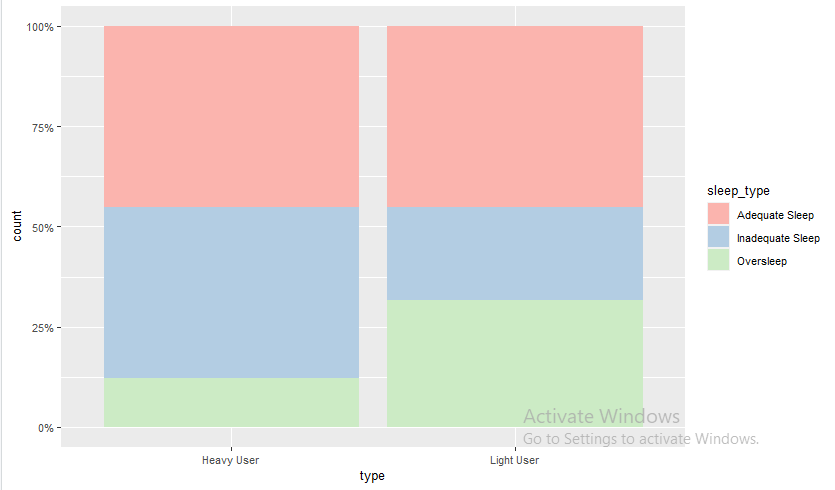

**Inference :**

We can see that though similar percentage of people get enough sleep in both the types, more percentage of Heavy Users tend to get Inadequate sleep than that of Light users

In [ ]:
only_sleep_clean$sleep_hrs <- (only_sleep_clean$TotalMinutesAsleep)/60

only_sleep_clean %>% 
  ggplot(aes(x=type,y=sleep_hrs,fill=type)) + geom_violin(scale='area',alpha=.5) + geom_dotplot(binaxis = 'y',stackdir = 'center',dotsize = .5,color= 'black') +scale_fill_brewer(palette = 'Pastel2')+
  ylab("Sleep in Hrs") +
  xlab("Type") +
  theme(legend.position = 'none') +
  labs(title = "Type Vs Hrs")


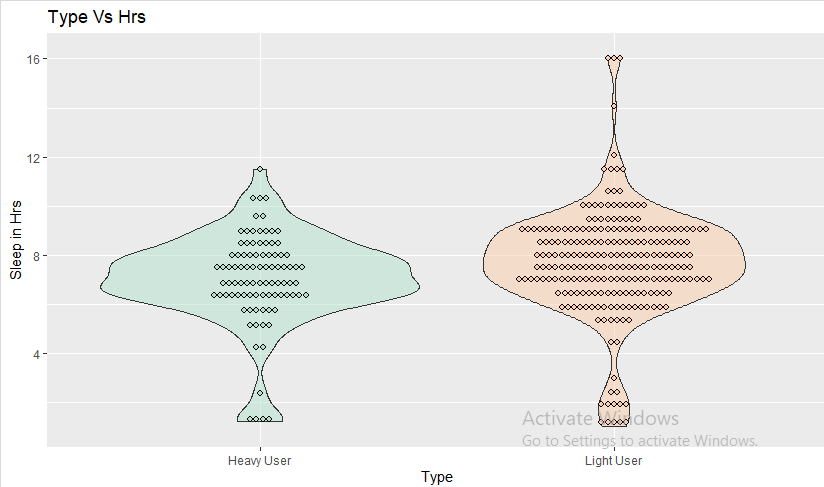

Next up, We'll see relationship between the calories burned and the day.

In [ ]:
only_sleep_clean$Day = weekdays(as.Date(only_sleep_clean$DAte,'%m/%d/%Y'))
only_sleep_clean$Day = factor(only_sleep_clean$Day,levels=c('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'))

only_sleep_clean %>% 
  ggplot(aes(x=Day,y = Calories,fill=type)) + geom_boxplot(outlier.colour = 'red', outlier.shape = 8)+
  theme(legend.position = 'none') +
  stat_summary(fun.y=mean, geom="point", shape=21, size=4)

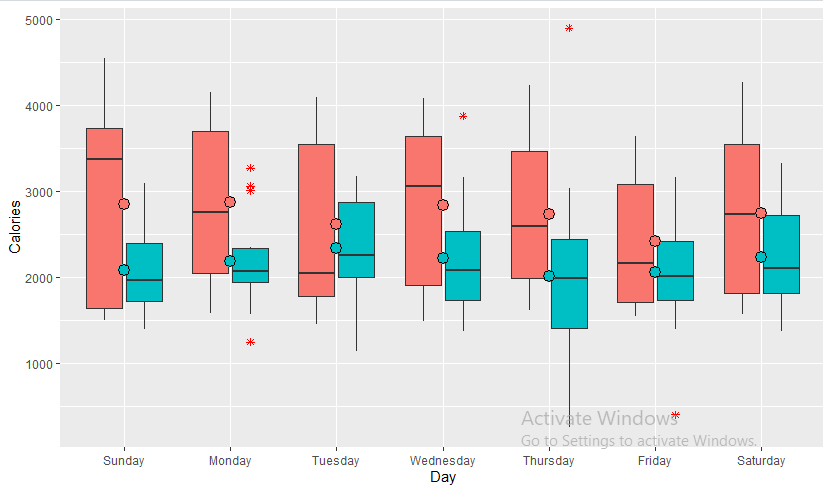

# Inferences

* Most of the people in the sample are **light users.**
* Heavy users mostly burn calories in the range of **1800 to 3600** whereas, Light users mostly burn calories in the range of **1700 to 2500.**
* Most of the sample population is concentrated around the **'2000 calories burned'** mark.
* As TotalDistance increases Calories also increases, but not so linearly which means the users are **not only burning their calories through travelling by foot but my also other means**.
* With respect to step counts, below **10000 mark** comprises mostly of **light users** and above 10000,Heavy users.
* Most of the users travel a distance between **10 and 15 daily**.
* Generally, heavy user tend to get less sleep than that of Light Users.
* Around **52-56 percent** of light and heavy users tend to get **adequate sleep**. But **37-40 percent** of heavy users get **inadequate sleep**, whereas only **15-17 percent** of light users get **inadequate sleep.**

# Steps that can be taken by the company

* As Light users dominate the list, the company can focus on features that will be important for **casual users such as Aesthetics, battery life etc.**
* By inference point 4, we can see a lot of people burn calories through some other means other than jogging, running, walking. So the company can focus on **improving their products** for other activities like **swimming, yoga, gym workouts, and much more.**
* A lot of people in the data **do not get sufficient sleep**, so the company can **improve user interface and features** to let people know about this. For instance, they can set a **warning** to be shown on the watch when the people don't get enough sleep. They can also improve their **sleep tracking**, **mute notifications** in their mobile when they are sleeping, etc. 

# 